# TSFEL Feature selection (Preprocessing)

In this notebook, we try out 2 methods for feature selection using the TSFEL library. We first remove all the constant features from the dataset. Then we use 2 methods for feature selection:

1. Variance thresholding
2. Select K best features using ANOVA F-test

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import shutil

## Removing constant features

In this section we remove the features which remain constant throughout the dataset. These features do not provide any information to the model and can be removed.

In [2]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):  # Ensure we're only loading CSV files
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels)  # Corresponding labels
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded
base_dir = 'Datasets/TSFEL_3axes_allfeatures'

X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1) 
X_combined = np.concatenate((X_train_flat, X_test_flat), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

selector = VarianceThreshold(threshold=0.0)
X_combined_reduced = selector.fit_transform(X_combined)

constant_features_idx = np.where(selector.variances_ == 0)[0]

print(f"Constant features: {constant_features_idx}")

num_features_removed = len(constant_features_idx)
print(f"Number of constant features removed: {num_features_removed}")

final_feature_count = X_combined_reduced.shape[1]
print(f"Final dataset size after removing constant features: {X_combined_reduced.shape}")

X_train_flat = X_combined_reduced[:X_train_flat.shape[0], :]
X_test_flat = X_combined_reduced[X_train_flat.shape[0]:, :]



Constant features: [  6   7  10  11  12  13  14  15  16  17  18  19 274 275 276 397 398 401
 402 403 404 405 406 407 408 409 410 788 789 792 793 794 795 796 797 798
 799 800 801]
Number of constant features removed: 39
Final dataset size after removing constant features: (180, 1134)




## Method 1: Variance Thresholding

- We remove all features that have low variance. This is because features with low variance do not contain much information. We can use the `VarianceThreshold` class from `sklearn.feature_selection` to remove features with low variance.
- To see how what the variance threshold should be, we train a Decision Tree Classifier, a Random Forest Classifier and XGBoost Classifier on the training + testing data and plot the accuracy of the model against the variance threshold, after 5 fold cross validation. We do not do any nested cross validation, since there is no hyperparameter tuning involved. 

### Results:
- We see that the after variance thresholding, for just 130 features, we see a reasonably high accuracy with the default scikit learn implementations of Random Forest and Decision Trees. Therefore, we shall use a variance threshold as the variance threshold. 

Threshold: 0.000 - Features: 1134 - RF CV Accuracy: 0.9222 - DT CV Accuracy: 0.8389
Threshold: 0.010 - Features: 284 - RF CV Accuracy: 0.9111 - DT CV Accuracy: 0.8500
Threshold: 0.020 - Features: 258 - RF CV Accuracy: 0.9111 - DT CV Accuracy: 0.8444
Threshold: 0.030 - Features: 237 - RF CV Accuracy: 0.9167 - DT CV Accuracy: 0.8389
Threshold: 0.040 - Features: 219 - RF CV Accuracy: 0.9167 - DT CV Accuracy: 0.8389
Threshold: 0.050 - Features: 212 - RF CV Accuracy: 0.9167 - DT CV Accuracy: 0.8389
Threshold: 0.060 - Features: 207 - RF CV Accuracy: 0.9056 - DT CV Accuracy: 0.8333
Threshold: 0.070 - Features: 207 - RF CV Accuracy: 0.9056 - DT CV Accuracy: 0.8333
Threshold: 0.080 - Features: 203 - RF CV Accuracy: 0.9167 - DT CV Accuracy: 0.8500
Threshold: 0.090 - Features: 188 - RF CV Accuracy: 0.9056 - DT CV Accuracy: 0.8278
Threshold: 0.100 - Features: 187 - RF CV Accuracy: 0.9111 - DT CV Accuracy: 0.8389
Threshold: 0.110 - Features: 181 - RF CV Accuracy: 0.9111 - DT CV Accuracy: 0.8389
Thr

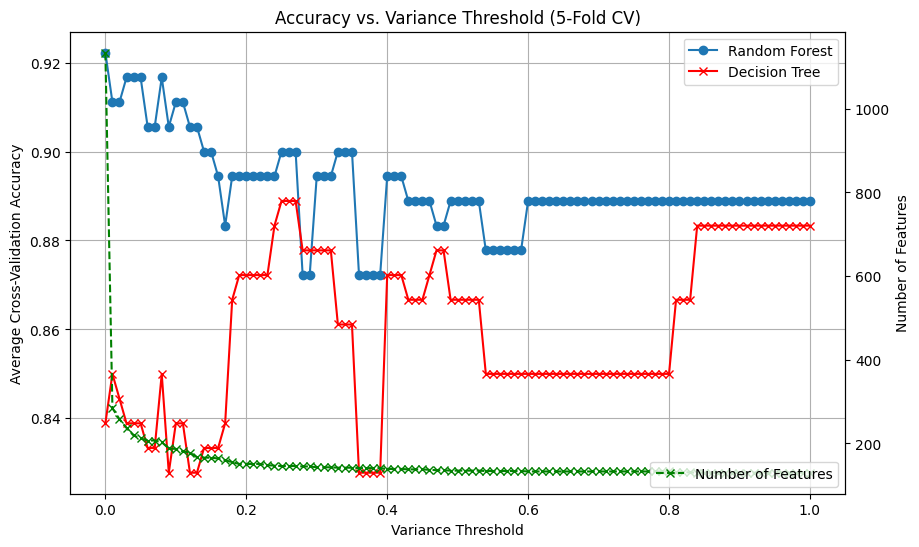

In [3]:
variance_thresholds = np.arange(0.00, 1.01, 0.01)

avg_accuracies_rf = []
avg_accuracies_dt = []
num_features_list = []

kf = KFold(n_splits=5, shuffle=True, random_state=0)

for threshold in variance_thresholds:
    variance_selector = VarianceThreshold(threshold=threshold)
    X_combined_reduced = variance_selector.fit_transform(X_combined)
    
    num_features = X_combined_reduced.shape[1]
    num_features_list.append(num_features)
    
    clf_rf = RandomForestClassifier(n_estimators=200, random_state=0)
    
    cv_scores_rf = cross_val_score(clf_rf, X_combined_reduced, y_combined, cv=kf, scoring='accuracy')
    
    avg_accuracy_rf = np.mean(cv_scores_rf)
    avg_accuracies_rf.append(avg_accuracy_rf)
    
    clf_dt = DecisionTreeClassifier(random_state=0)
    
    cv_scores_dt = cross_val_score(clf_dt, X_combined_reduced, y_combined, cv=kf, scoring='accuracy')
    
    avg_accuracy_dt = np.mean(cv_scores_dt)
    avg_accuracies_dt.append(avg_accuracy_dt)
    
    print(f"Threshold: {threshold:.3f} - Features: {num_features} - RF CV Accuracy: {avg_accuracy_rf:.4f} - DT CV Accuracy: {avg_accuracy_dt:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(variance_thresholds, avg_accuracies_rf, marker='o', label='Random Forest')
plt.plot(variance_thresholds, avg_accuracies_dt, marker='x', color='red', label='Decision Tree')
plt.title('Accuracy vs. Variance Threshold (5-Fold CV)')
plt.xlabel('Variance Threshold')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)
plt.legend(loc='upper right')

plt.twinx()
plt.plot(variance_thresholds, num_features_list, marker='x', color='green', linestyle='--', label='Number of Features')
plt.ylabel('Number of Features')
plt.legend(loc='lower right')

plt.show()

## Method 2: Select K best features using ANOVA F-test

- We use the `SelectKBest` class from `sklearn.feature_selection` to select the best features using ANOVA F-test.
- We train a Decision Tree Classifier, a Random Forest Classifier on the training + testing data and plot the accuracy of the model against the number of features, after 5 fold cross validation. We do not do any nested cross validation, since there is no hyperparameter tuning involved.
- We see that for just 60 features, we see a reasonably high accuracy with the default scikit learn implementations of Random Forest and Decision Trees. Therefore, we shall use 60 as the number of features to select.

### Results:
- Here, we see that just 60 features, we get a reasonably high accuracy with the default scikit learn implementations of Random Forest and Decision Trees. Therefore, we shall use 60 as the number of features to select using ANOVA F-test.

Thus, we shall finally use the ANOVA F-test to select the best 60, while ignoring most of the other redundant features.

With top 10 features:
Random Forest - Average CV Accuracy with 10 features: 0.8335
Decision Tree - Average CV Accuracy with 10 features: 0.8009
With top 20 features:
Random Forest - Average CV Accuracy with 20 features: 0.8649
Decision Tree - Average CV Accuracy with 20 features: 0.8166
With top 30 features:
Random Forest - Average CV Accuracy with 30 features: 0.8569
Decision Tree - Average CV Accuracy with 30 features: 0.7606
With top 40 features:
Random Forest - Average CV Accuracy with 40 features: 0.8726
Decision Tree - Average CV Accuracy with 40 features: 0.7929
With top 50 features:
Random Forest - Average CV Accuracy with 50 features: 0.8643
Decision Tree - Average CV Accuracy with 50 features: 0.8726
With top 60 features:
Random Forest - Average CV Accuracy with 60 features: 0.8963
Decision Tree - Average CV Accuracy with 60 features: 0.8960
With top 70 features:
Random Forest - Average CV Accuracy with 70 features: 0.9043
Decision Tree - Average CV Accuracy with 70 features:

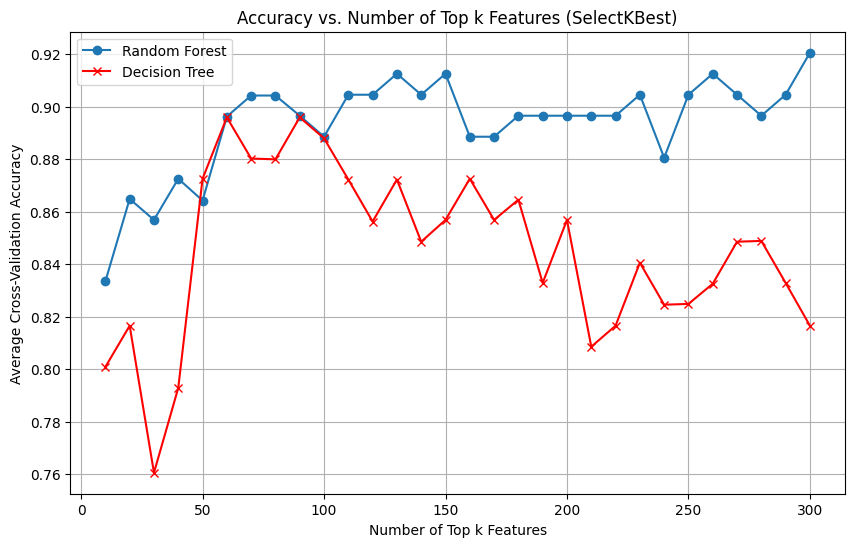

In [7]:
k_values = np.arange(10, 301, 10)

avg_accuracies_rf = []
avg_accuracies_dt = []

for k in k_values:
    selector = SelectKBest(f_classif, k=k)
    
    X_train_flat_reduced = selector.fit_transform(X_train_flat, y_train)
    X_test_flat_reduced = selector.transform(X_test_flat)
    clf_rf = RandomForestClassifier(n_estimators=300, random_state=42)
    cv_scores_rf = cross_val_score(clf_rf, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')
    avg_accuracy_rf = np.mean(cv_scores_rf)
    avg_accuracies_rf.append(avg_accuracy_rf)
    
    
    clf_dt = DecisionTreeClassifier(random_state=42)
    cv_scores_dt = cross_val_score(clf_dt, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')
    avg_accuracy_dt = np.mean(cv_scores_dt)
    avg_accuracies_dt.append(avg_accuracy_dt)
    print(f"With top {k} features:")
    print(f"Random Forest - Average CV Accuracy with {k} features: {avg_accuracy_rf:.4f}")
    print(f"Decision Tree - Average CV Accuracy with {k} features: {avg_accuracy_dt:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_accuracies_rf, marker='o', label='Random Forest')
plt.plot(k_values, avg_accuracies_dt, marker='x', label='Decision Tree', color='red')
plt.title('Accuracy vs. Number of Top k Features (SelectKBest)')
plt.xlabel('Number of Top k Features')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

### We see that 60 features are enough to get a reasonably high accuracy. 

In [5]:
k = 60

selector = SelectKBest(f_classif, k=k)
X_train_flat_reduced = selector.fit_transform(X_train_flat, y_train)
X_test_flat_reduced = selector.transform(X_test_flat)

selected_feature_indices = selector.get_support(indices=True)

print("Top 60 selected feature indices:")
print(selected_feature_indices)

# Proceed with training RandomForest and DecisionTree as before...

clf_rf = RandomForestClassifier(n_estimators=300, random_state=42)

cv_scores_rf = cross_val_score(clf_rf, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')

avg_accuracy_rf = np.mean(cv_scores_rf)
print(f"Random Forest - Average CV Accuracy with {k} features: {avg_accuracy_rf:.4f}")

clf_dt = DecisionTreeClassifier(random_state=42)

cv_scores_dt = cross_val_score(clf_dt, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')

avg_accuracy_dt = np.mean(cv_scores_dt)
print(f"Decision Tree - Average CV Accuracy with {k} features: {avg_accuracy_dt:.4f}")


Top 60 selected feature indices:
[   0    1    3    6    7  260  298  300  302  303  304  306  308  311
  315  319  325  335  336  339  340  341  342  343  344  345  346  347
  348  349  350  351  352  353  354  355  357  358  359  360  361  362
  363  364  365  374  679  683  687  689  690  715  726  727  728  736
  737  738  744 1058]
Random Forest - Average CV Accuracy with 60 features: 0.8963
Decision Tree - Average CV Accuracy with 60 features: 0.8960


# Saving the selected features to TSFEL_3axes_filteredfeatures

In [ ]:
import os
import shutil

original_dir = 'Datasets/TSFEL_3axes_allfeatures'
filtered_dir = 'Datasets/TSFEL_3axes_filteredfeatures'

shutil.copytree(original_dir, filtered_dir)

feature_names = None

for root, dirs, files in os.walk(filtered_dir):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            
            df = pd.read_csv(file_path)
            
            if feature_names is None:
                feature_names = df.columns.tolist()
            
            df_filtered = df.iloc[:, selected_feature_indices]
            
            df_filtered.to_csv(file_path, index=False)

if feature_names is not None:
    print("List of features in the dataset:")
    for i, feature in enumerate(feature_names):
        print(f"{i+1}: {feature}")

print(f"Filtered features saved in the directory: {filtered_dir}")
